In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

In [3]:
date_cols=['date_activ','date_end','date_modif_prod','date_renewal']
df = pd.read_csv('./clean_data_after_eda.csv',parse_dates=date_cols)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


In [4]:
df.shape

(14606, 44)

In [5]:
df.dtypes

id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act         

In [6]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [8]:
monthly_price_by_id.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885


In [9]:
jan_prices.head()

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-01-01,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-01-01,0.150837,44.444710
3,0010ee3855fdea87602a5b7aba8e42de,2015-01-01,0.123086,40.565969
4,00114d74e963e47177db89bc70108537,2015-01-01,0.149434,44.266931


In [10]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


In [11]:
df['has_gas']=df['has_gas'].replace(['t','f'],[1,0])

In [12]:
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [13]:
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [14]:
numeric_features = df[[
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]]
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,159220.286252,573465.264198,0.0,5674.750000,14115.500000,40763.750000,6.207104e+06
cons_gas_12m,14606.0,28092.375325,162973.059057,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14606.0,16090.269752,64364.196422,0.0,0.000000,792.500000,3383.000000,7.712030e+05
forecast_cons_12m,14606.0,1868.614880,2387.571531,0.0,494.995000,1112.875000,2401.790000,8.290283e+04
forecast_cons_year,14606.0,1399.762906,3247.786255,0.0,0.000000,314.000000,1745.750000,1.753750e+05
forecast_discount_energy,14606.0,0.966726,5.108289,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14606.0,63.086871,66.165783,0.0,16.180000,18.795000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14606.0,0.137283,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14606.0,0.050491,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01
forecast_price_pow_off_peak,14606.0,43.130056,4.485988,0.0,40.606701,44.311378,44.311378,5.926638e+01


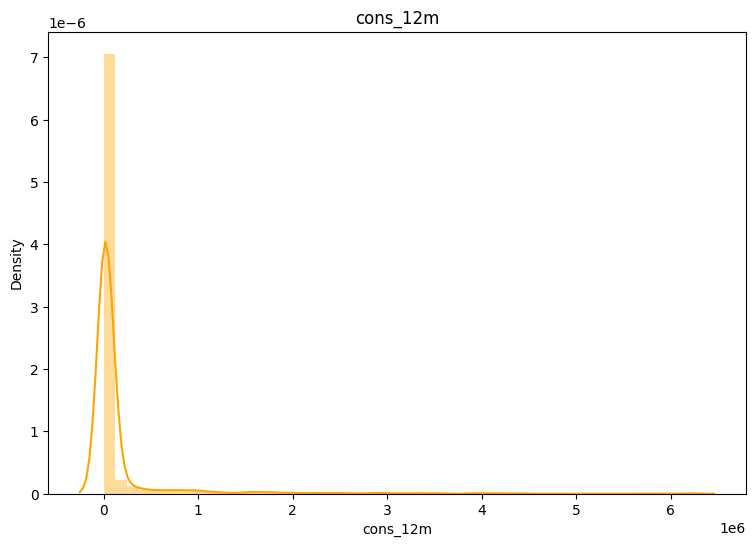

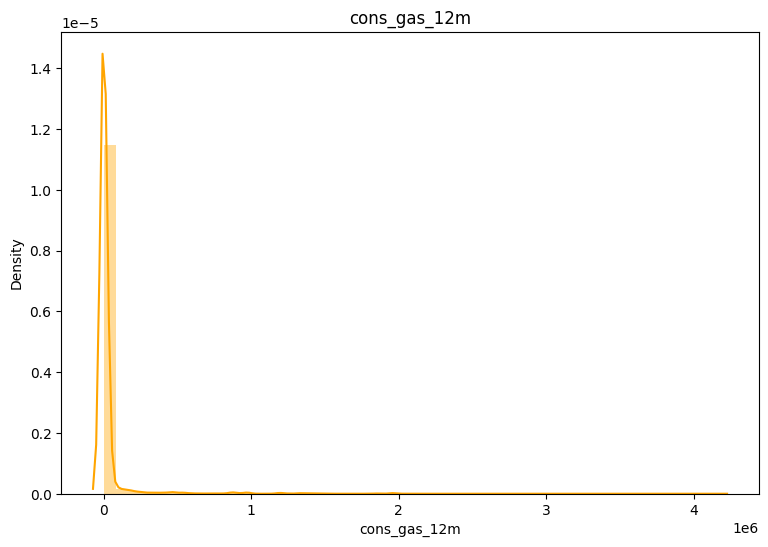

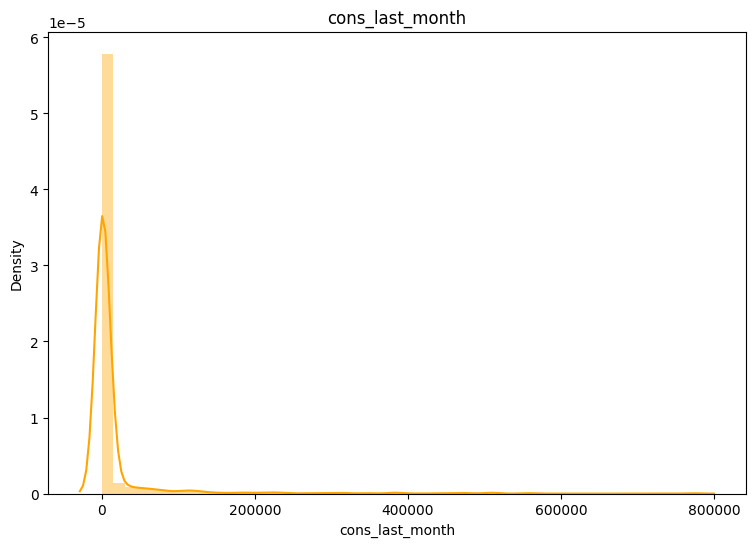

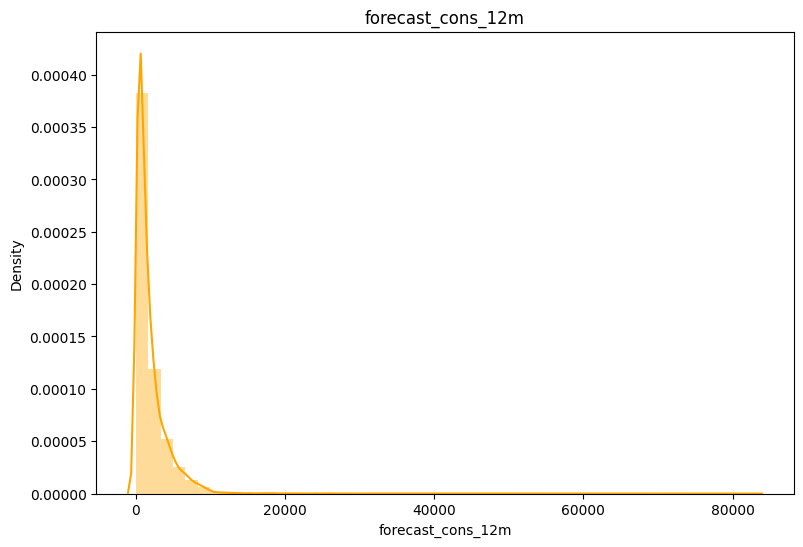

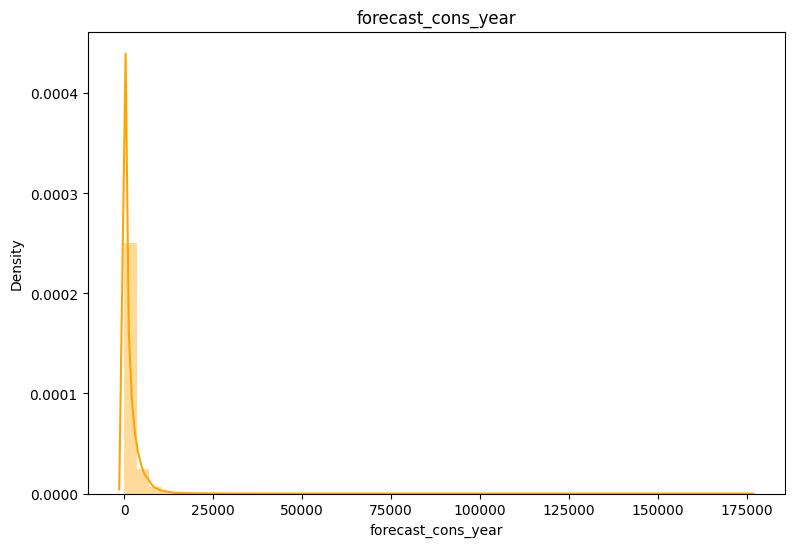

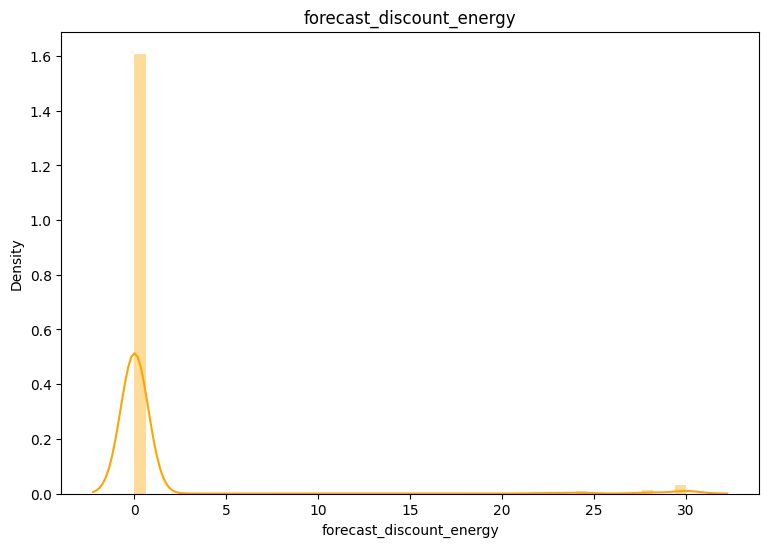

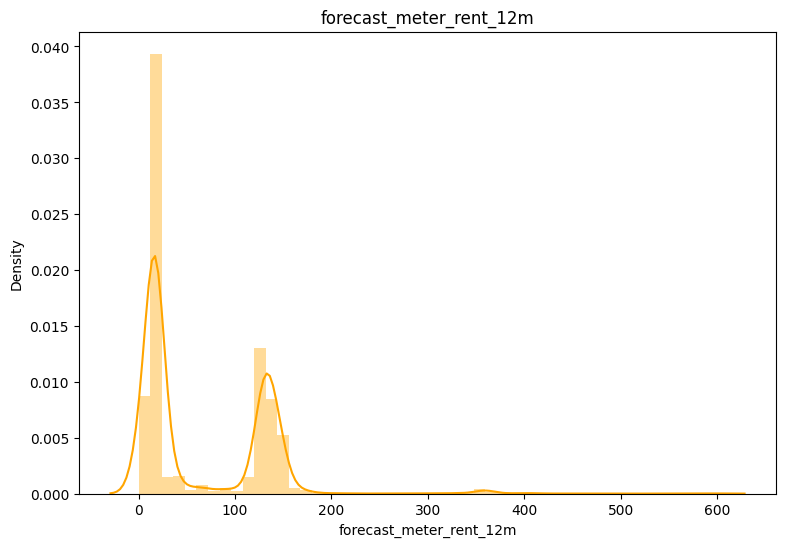

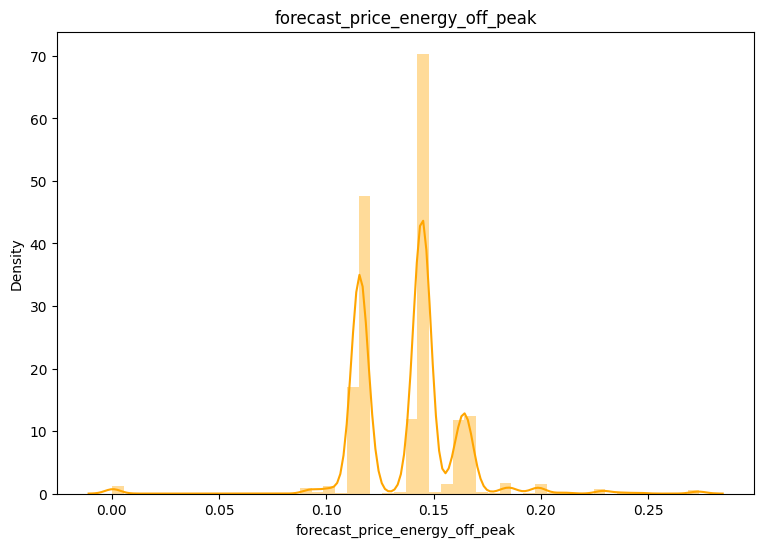

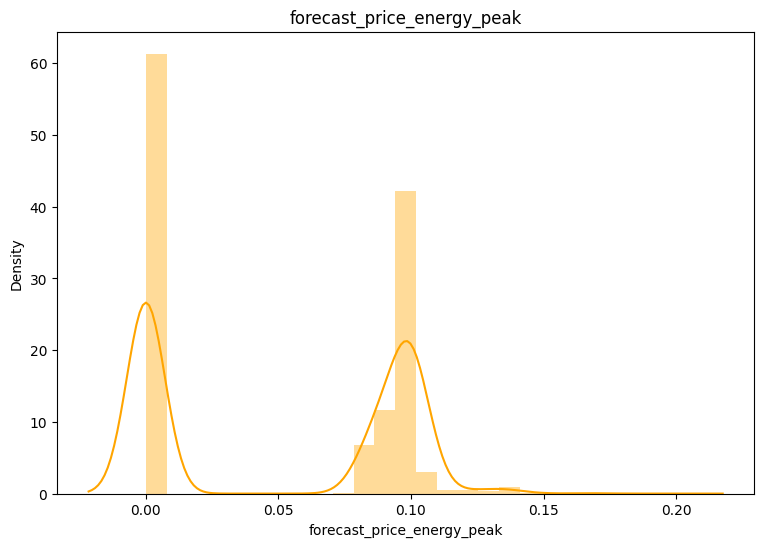

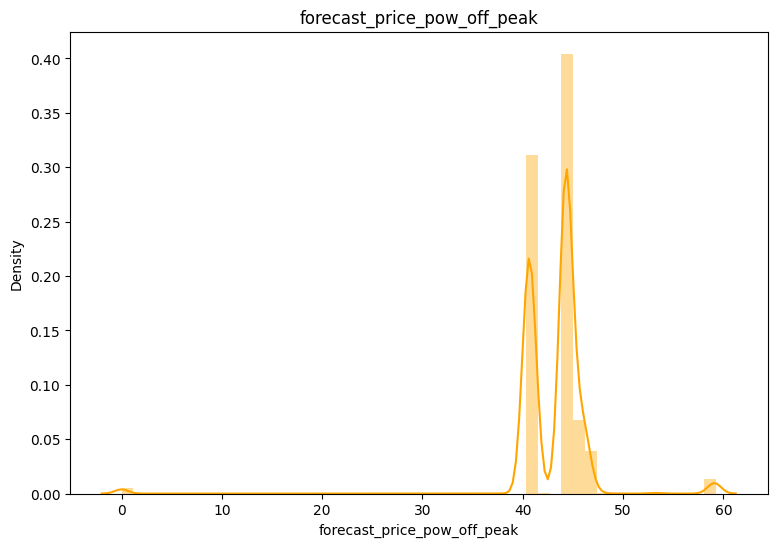

In [19]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax = ax, color="orange")
    ax.set_title(col)
plt.show()

In [20]:
for i in numeric_features:
    df[i]=df[i].apply(lambda x:np.log(1+x))

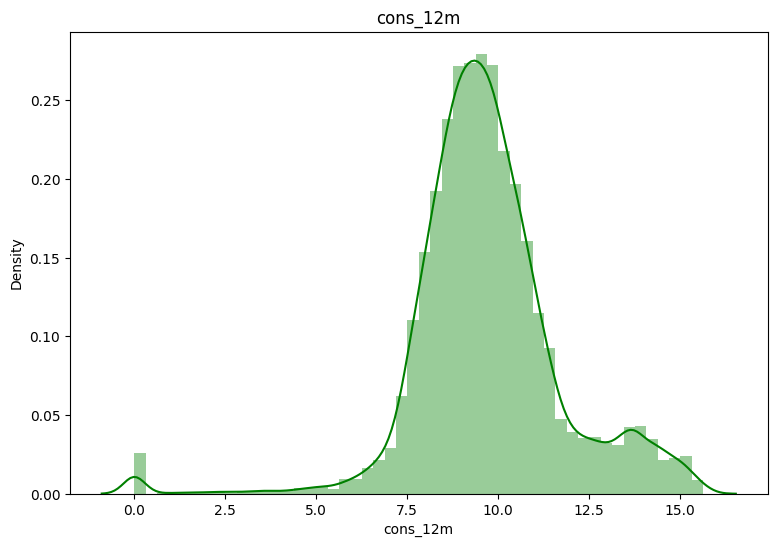

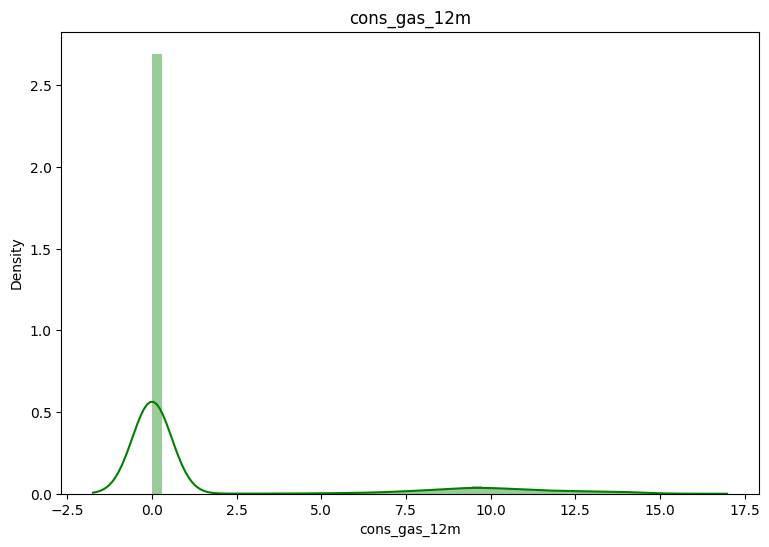

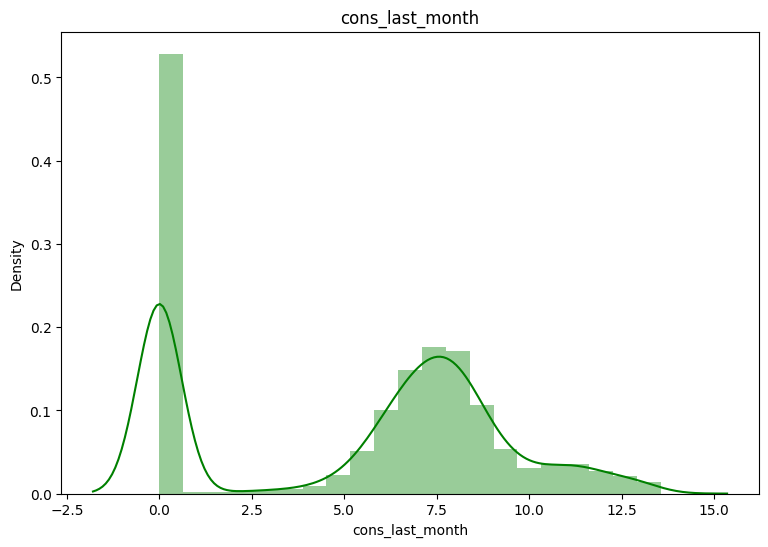

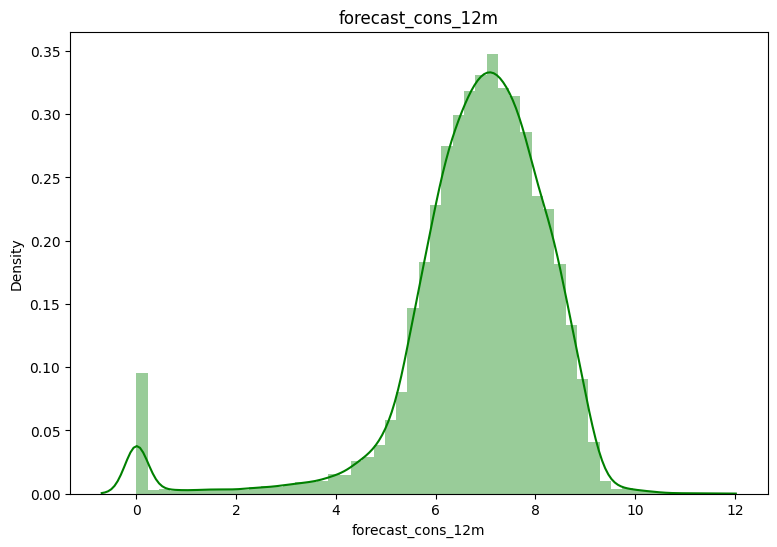

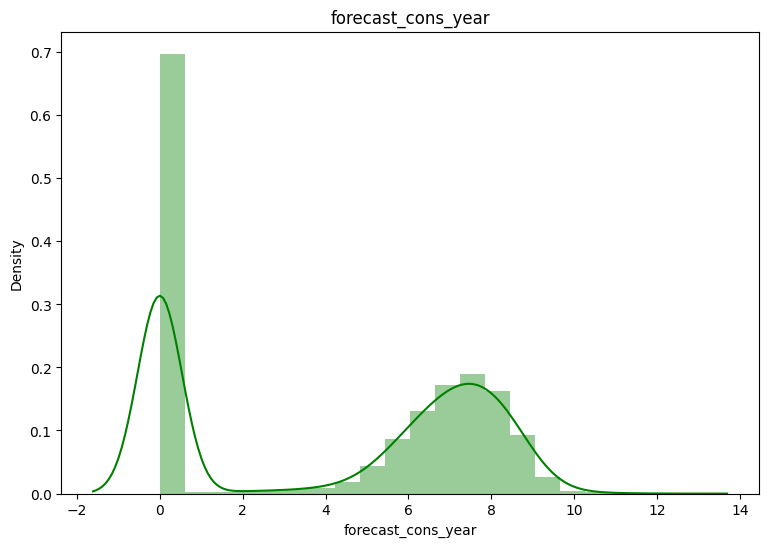

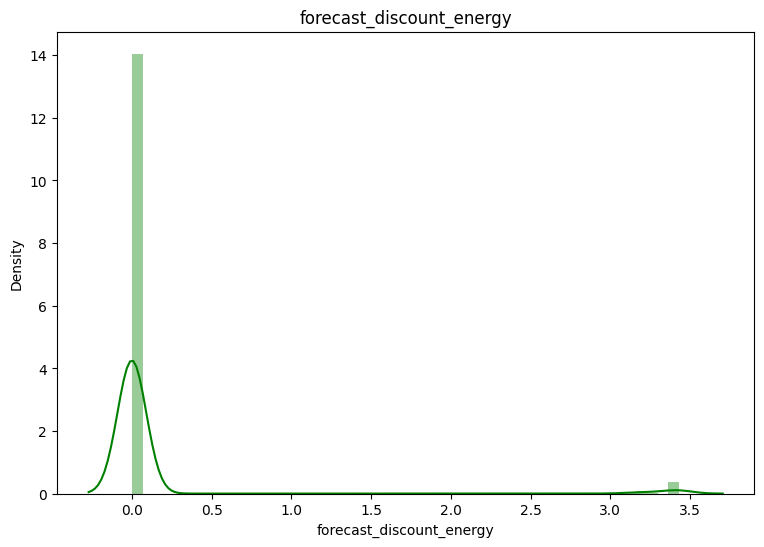

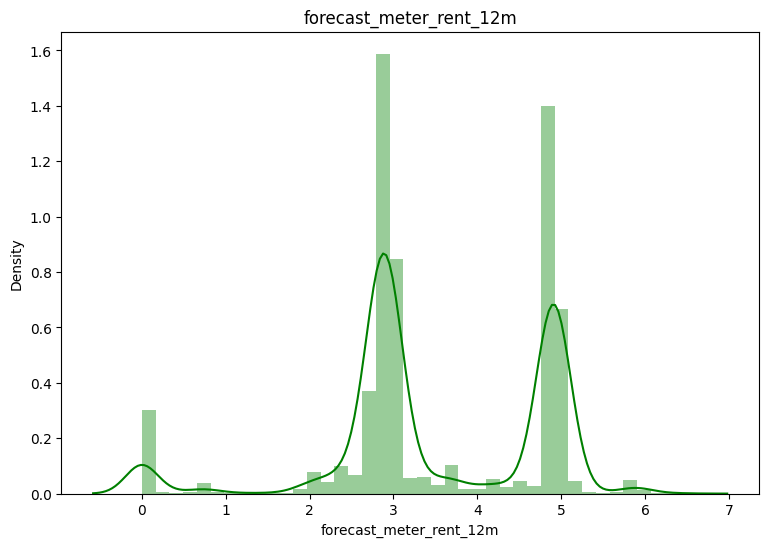

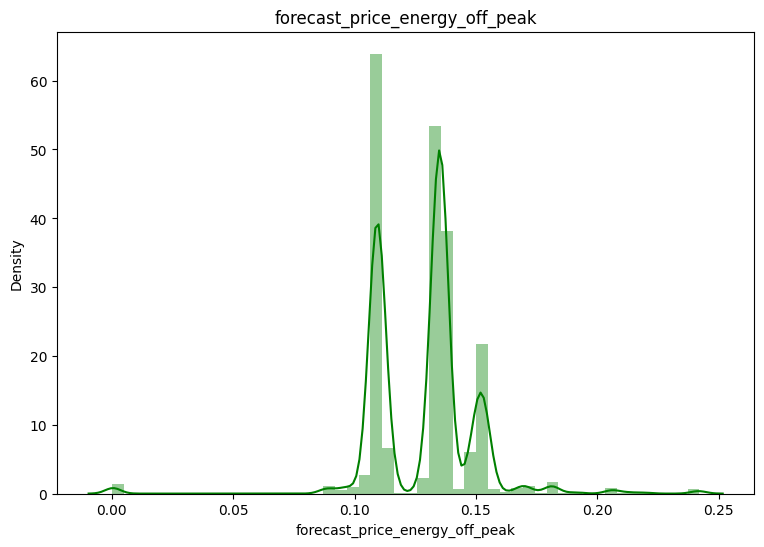

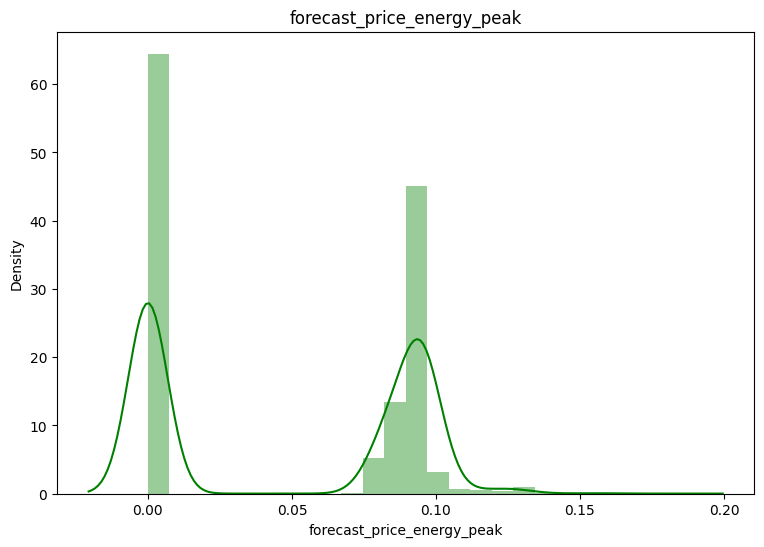

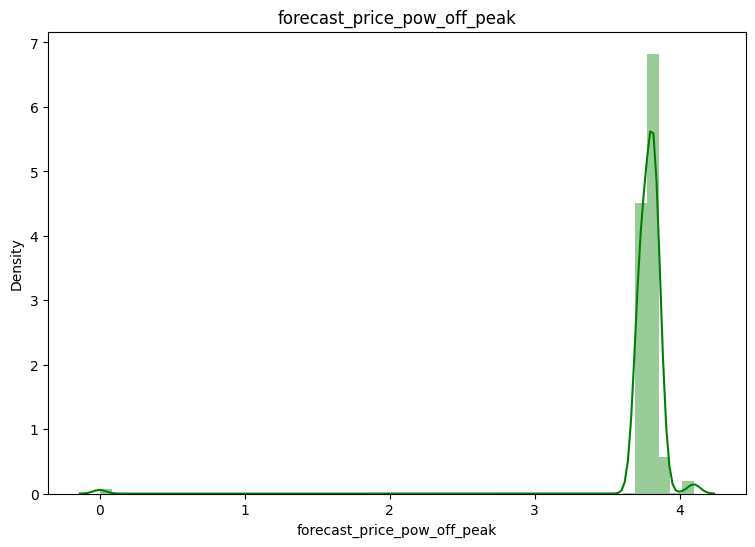

In [22]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    sns.distplot(feature, ax = ax, color="green")
    ax.set_title(col)
plt.show()

In [25]:
correlation = df.corr(numeric_only=True)


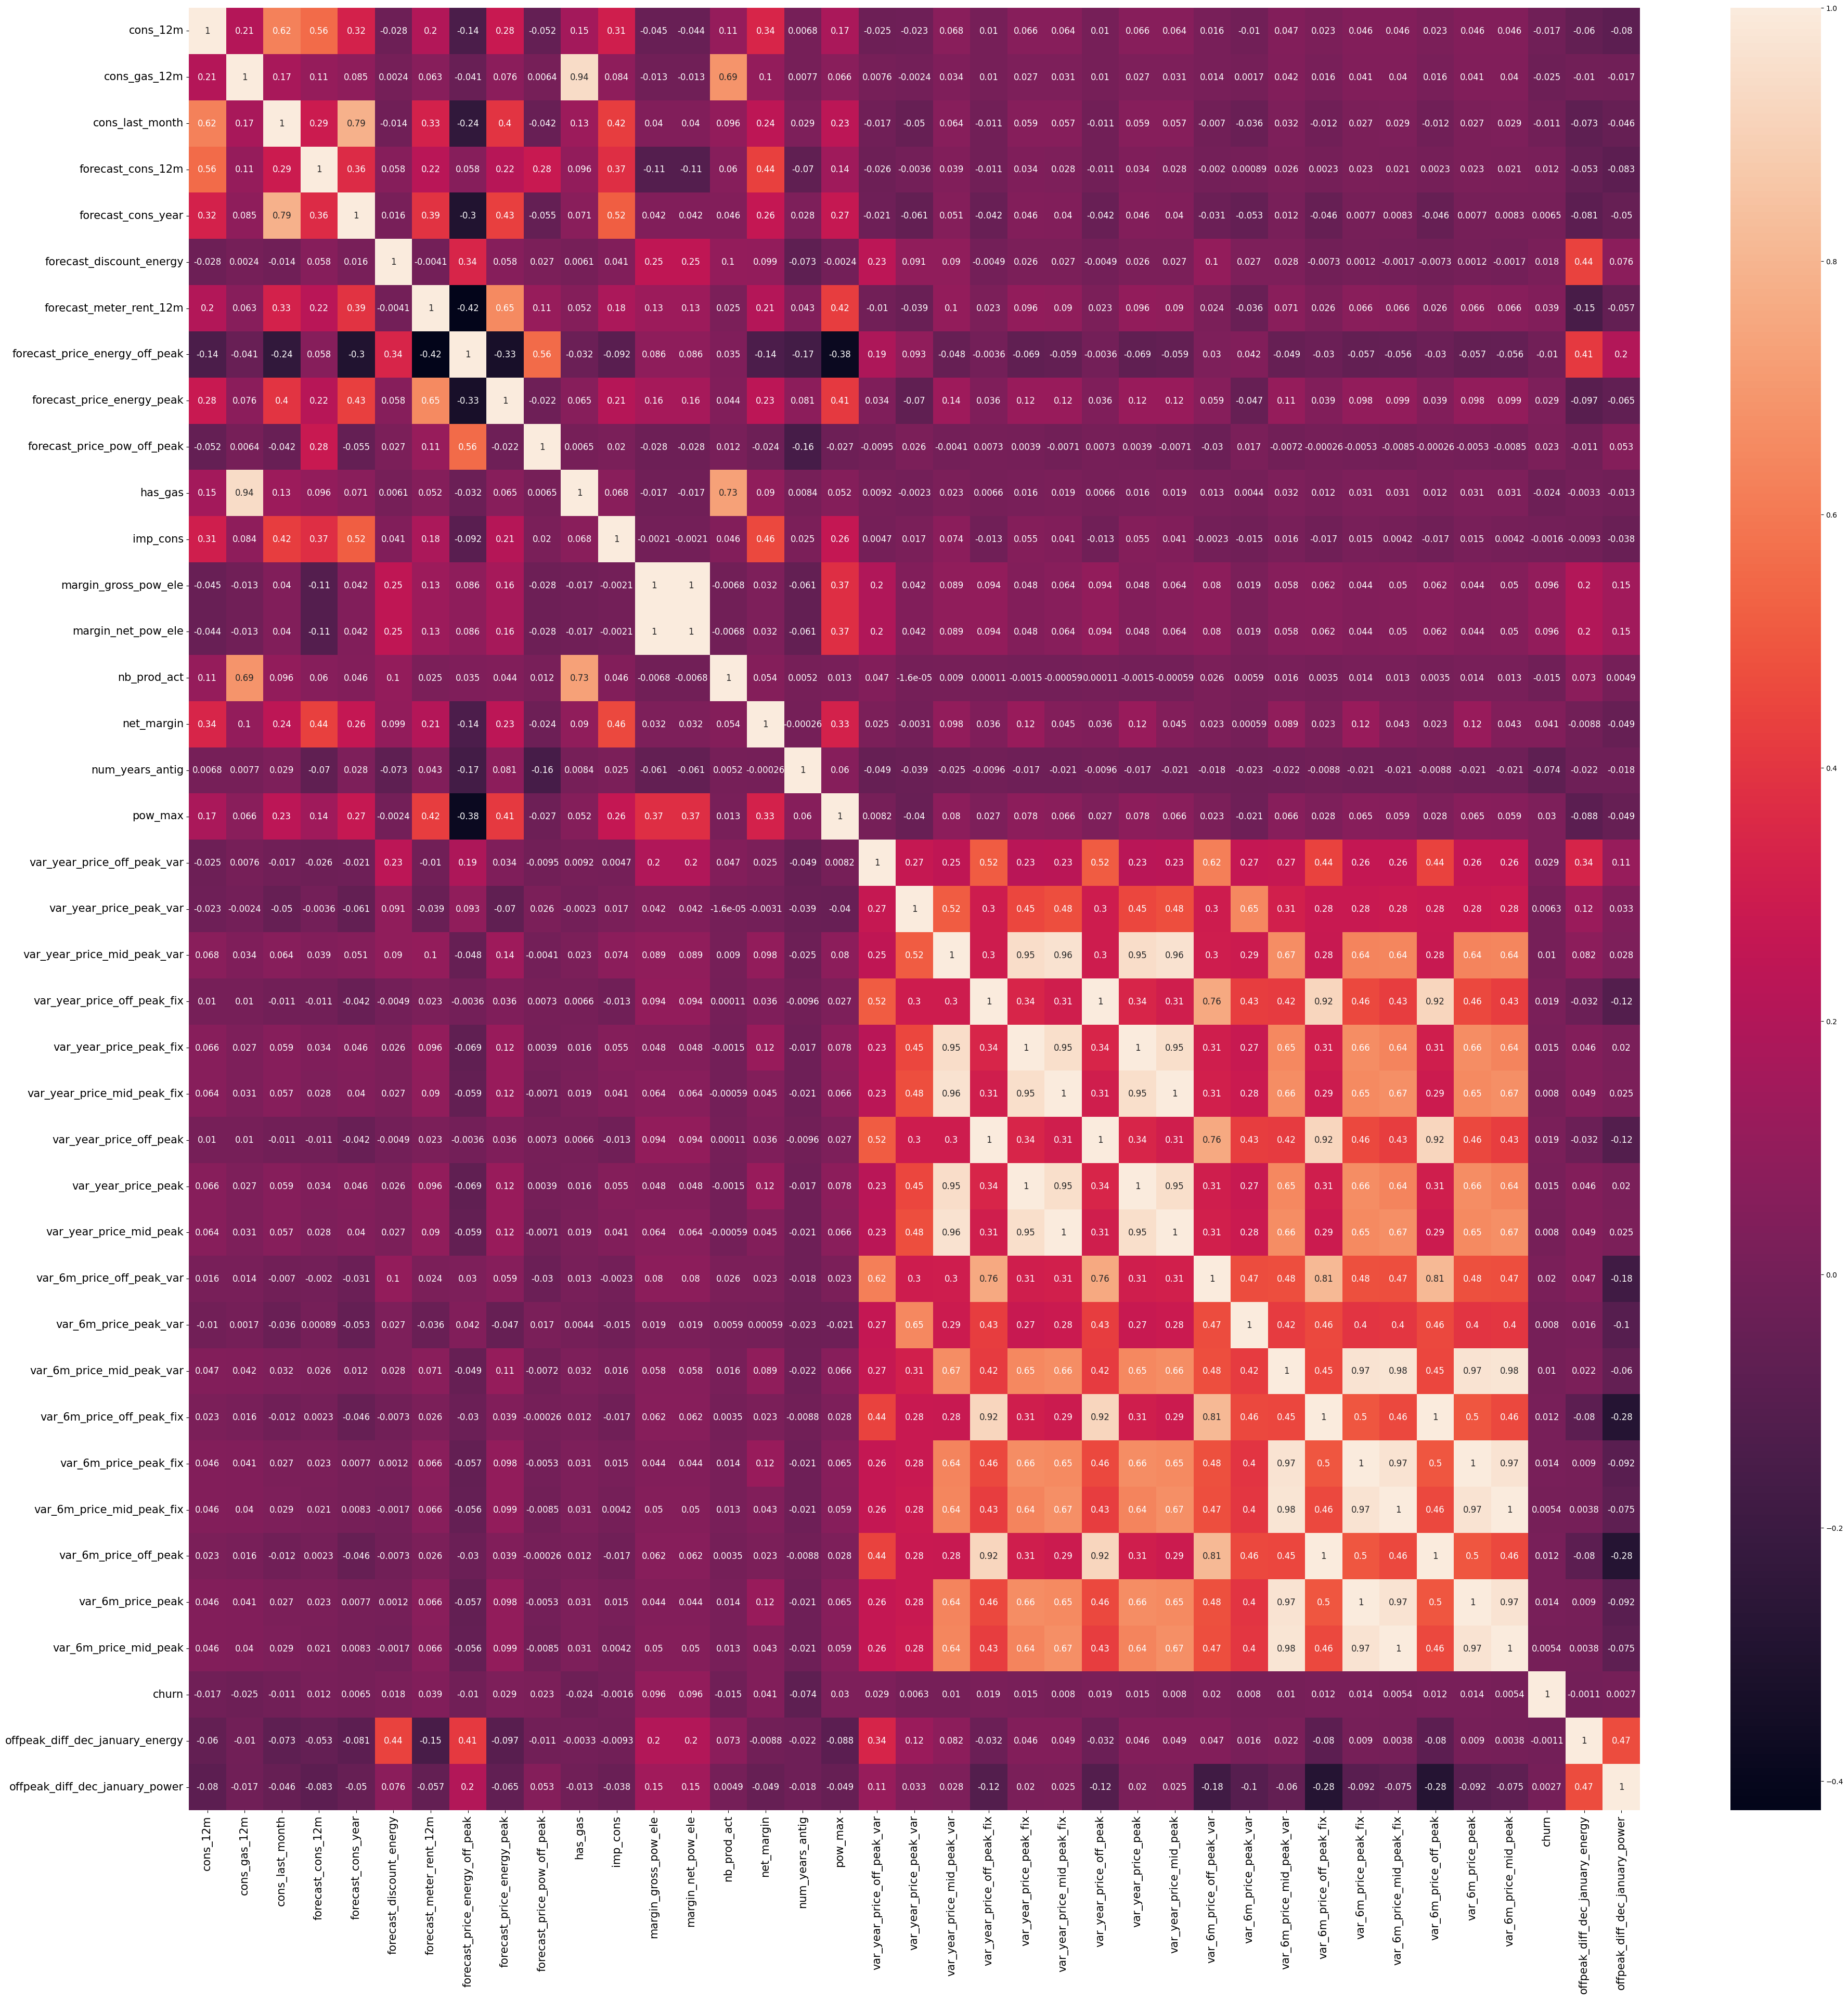

In [26]:
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()